In [152]:
import config
import os
import datetime
import random
import pandas as pd
import dask
import dask.dataframe as dd

import numpy as np

import math
import geopandas as gpd
from shapely.geometry import Polygon
import scienceplots
import matplotlib.pyplot as plt
plt.style.use(['science'])


def gps_to_grid(lat, lon):
    """ Calculate grid index for a given GPS coordinate """
    lat_index = int((lat - (min_lat - delta_lat / 2)) / delta_lat)
    lon_index = int((lon - (min_lon - delta_lon / 2)) / delta_lon)
    return lat_index, lon_index

def grid_to_gps(lat_index, lon_index):
    """ Calculate GPS coordinates of the center point for a given grid index """
    lat = lat_index * delta_lat + min_lat
    lon = lon_index * delta_lon + min_lon
    return lat, lon

def unix_to_datetime(timestamp: str) -> datetime:
    """
    convert unix to datetime
    >>> dt = unix_to_datetime('1538402919')
    >>> print(dt.strftime('%Y/%m/%d %H:%M:%S'))
    2018/10/01 22:08:39
    """
    return datetime.datetime.fromtimestamp(int(timestamp))

dataset = config.chengdu_dataset

# Preparation: cleaned, selected, expended

## Duplicates

In [2]:
filepaths = [os.path.join(dataset, i) 
                 for i in os.listdir(dataset) 
                 if i.startswith('chengdu') and i.endswith('.csv')]

ddf_origin = dd.read_csv(filepaths, header=None, names=['oid', 'wid', 'traj'], blocksize=64e6)
ddf_origin.head()

,oid,wid,traj
0,92a1d44607c036fbc9db971258c0e013,f5e36c97e4a8052a2aa9c7f8ed0f969a,"[104.04538 30.70745 1538402919, 104.04538 30.7..."
1,0e95f18113ad01cf626289344fd39f4e,c5f1bba8b2cfad357a9ed65dc3021ff1,"[104.08169 30.6705 1538406898, 104.08169 30.67..."
2,7dceae818438b836e3d306296b4ccfbd,0e3f29616d126177f5db9bfb27be21de,"[104.04235 30.69204 1538334938, 104.04268 30.6..."
3,94bba68a63c866769c1c3b37834518fa,c480964f535eede621a1ac4dde7073a6,"[104.04714 30.7263 1538345323, 104.04698 30.72..."
4,8601cc60cfea2fc7f599ebf9b2a4d977,5f3cabc6ff9083e6c79f3f798a9c17e2,"[104.11542 30.65289 1538322576, 104.11574 30.6..."


In [3]:
output_cleaned = os.path.join(dataset, 'cleaned')

if not os.path.exists(output_cleaned) or len(os.listdir(output_cleaned)) == 0:
    os.makedirs(output_cleaned, exist_ok=True)
    ddf_origin = dd.read_csv(filepaths, header=None, names=['oid', 'wid', 'traj'])
    # remove duplicate record
    oid_counts = ddf_origin['oid'].value_counts().compute()
    duplicate_orders = (oid_counts[oid_counts > 1]).index.tolist()
    ddf_origin[~ddf_origin['oid'].isin(duplicate_orders)].to_parquet(output_cleaned)

cleaned_files = [os.path.join(output_cleaned, i) 
                 for i in os.listdir(output_cleaned) 
                 if i.startswith('part') and i.endswith('.parquet')]

ddf_cleaned = dd.read_parquet(cleaned_files)
ddf_cleaned.head()

,oid,wid,traj
0,92a1d44607c036fbc9db971258c0e013,f5e36c97e4a8052a2aa9c7f8ed0f969a,"[104.04538 30.70745 1538402919, 104.04538 30.7..."
1,0e95f18113ad01cf626289344fd39f4e,c5f1bba8b2cfad357a9ed65dc3021ff1,"[104.08169 30.6705 1538406898, 104.08169 30.67..."
2,7dceae818438b836e3d306296b4ccfbd,0e3f29616d126177f5db9bfb27be21de,"[104.04235 30.69204 1538334938, 104.04268 30.6..."
3,94bba68a63c866769c1c3b37834518fa,c480964f535eede621a1ac4dde7073a6,"[104.04714 30.7263 1538345323, 104.04698 30.72..."
4,8601cc60cfea2fc7f599ebf9b2a4d977,5f3cabc6ff9083e6c79f3f798a9c17e2,"[104.11542 30.65289 1538322576, 104.11574 30.6..."


In [4]:
if not os.path.exists(os.path.join(dataset, 'workers.txt')):
    workers = wid_counts[wid_counts > 30].index.tolist() 
    print(len(workers))
    wid_counts[wid_counts > 30].to_csv(os.path.join(dataset, 'workers.txt'))
    
workers = pd.read_csv(os.path.join(dataset, 'workers.txt'))
workers

,wid,count
0,248e83a8ef8b7af1815873f9d488fb2b,769
1,9158ae4e303282353602a08135ca505e,737
2,eefefbc7788b7c934c97a19a52845228,718
3,92152394842cba2d5d19f12ebf22d44f,718
4,ad23645b75259f69658a11a1de55abb0,679
...,...,...
85012,e48d949a7a90f17d06fb73c99cde9fd7,31
85013,2b11d43ba53434c69dfb1ee8d7cffe27,31
85014,1521f29cf5a547d3ef622a0d1776a2ab,31
85015,7ed98cdc1851b653be6ecbe14d3b58b3,31


In [5]:
output_selected = os.path.join(dataset, 'selected')

if not os.path.exists(output_selected) or len(os.listdir(output_selected)) == 0:
    os.makedirs(output_selected, exist_ok=True)
    ddf_cleaned = dd.read_parquet(output_cleaned)
    ddf_cleaned[ddf_cleaned['wid'].isin(workers['wid'])].to_parquet(output_selected)

selected_files = [os.path.join(output_selected, i) 
                 for i in os.listdir(output_selected) 
                 if i.startswith('part') and i.endswith('.parquet')]

ddf_selected = dd.read_parquet(selected_files)
ddf_selected.head()

,oid,wid,traj
1,0e95f18113ad01cf626289344fd39f4e,c5f1bba8b2cfad357a9ed65dc3021ff1,"[104.08169 30.6705 1538406898, 104.08169 30.67..."
2,7dceae818438b836e3d306296b4ccfbd,0e3f29616d126177f5db9bfb27be21de,"[104.04235 30.69204 1538334938, 104.04268 30.6..."
3,94bba68a63c866769c1c3b37834518fa,c480964f535eede621a1ac4dde7073a6,"[104.04714 30.7263 1538345323, 104.04698 30.72..."
4,8601cc60cfea2fc7f599ebf9b2a4d977,5f3cabc6ff9083e6c79f3f798a9c17e2,"[104.11542 30.65289 1538322576, 104.11574 30.6..."
5,bc4ed5a4efc9d75add3b4767efe5aabf,c6cad4068fb04e30cda89c75673ee363,"[104.07026 30.72456 1538322724, 104.07011 30.7..."


## Format

In [6]:
peek = ddf_selected.head()
peek

,oid,wid,traj
1,0e95f18113ad01cf626289344fd39f4e,c5f1bba8b2cfad357a9ed65dc3021ff1,"[104.08169 30.6705 1538406898, 104.08169 30.67..."
2,7dceae818438b836e3d306296b4ccfbd,0e3f29616d126177f5db9bfb27be21de,"[104.04235 30.69204 1538334938, 104.04268 30.6..."
3,94bba68a63c866769c1c3b37834518fa,c480964f535eede621a1ac4dde7073a6,"[104.04714 30.7263 1538345323, 104.04698 30.72..."
4,8601cc60cfea2fc7f599ebf9b2a4d977,5f3cabc6ff9083e6c79f3f798a9c17e2,"[104.11542 30.65289 1538322576, 104.11574 30.6..."
5,bc4ed5a4efc9d75add3b4767efe5aabf,c6cad4068fb04e30cda89c75673ee363,"[104.07026 30.72456 1538322724, 104.07011 30.7..."


In [7]:
# peek.iloc[0,2][1:-1].split(',')

In [8]:
meta = pd.DataFrame({'wid': pd.Series(dtype='object'),
                     'oid': pd.Series(dtype='object'),
                     'lon': pd.Series(dtype='float64'),
                     'lat': pd.Series(dtype='float64'),
                     'dt': pd.Series(dtype='datetime64[ns]')})

def apply_func(row):
    wid, oid = row['wid'], row['oid']
    points = row['traj'][1:-1].split(',')
    data = []
    for point in points:
        lon, lat, timestamp = point.strip().split(' ')
        lon, lat = map(float, (lon, lat))
        # lon_index = int((lon - (min_lon - delta_lon / 2)) / delta_lon)
        # lat_index = int((lat - (min_lat - delta_lat / 2)) / delta_lat)
        dt = unix_to_datetime(timestamp)
        data.append({'wid': wid, 'oid': oid, 'lon': lon, 'lat': lat, 'dt': dt})
    return pd.DataFrame(data)

def process_partition(partition):
    return pd.concat([apply_func(row) for index, row in partition.iterrows()])

output_expended = os.path.join(dataset, 'expended')
if not os.path.exists(output_expended) or len(os.listdir(output_expended)) == 0:
    ddf_selected.map_partitions(process_partition, meta=meta).to_parquet(output_expended)
    
expended_files = [os.path.join(output_expended, i) 
                 for i in os.listdir(output_expended) 
                 if i.startswith('part') and i.endswith('.parquet')]

ddf_expanded = dd.read_parquet(expended_files)
ddf_expanded.head()

,wid,oid,lon,lat,dt
0,c5f1bba8b2cfad357a9ed65dc3021ff1,0e95f18113ad01cf626289344fd39f4e,104.08169,30.6705,2018-10-01 23:14:58
1,c5f1bba8b2cfad357a9ed65dc3021ff1,0e95f18113ad01cf626289344fd39f4e,104.08169,30.6705,2018-10-01 23:15:08
2,c5f1bba8b2cfad357a9ed65dc3021ff1,0e95f18113ad01cf626289344fd39f4e,104.08169,30.6705,2018-10-01 23:15:18
3,c5f1bba8b2cfad357a9ed65dc3021ff1,0e95f18113ad01cf626289344fd39f4e,104.08169,30.6705,2018-10-01 23:15:28
4,c5f1bba8b2cfad357a9ed65dc3021ff1,0e95f18113ad01cf626289344fd39f4e,104.08169,30.6705,2018-10-01 23:15:38


## Grids

In [9]:
# min_lat, max_lat, min_lon, max_lon = dd.compute(
#     ddf_expanded['lat'].min(),
#     ddf_expanded['lat'].max(),
#     ddf_expanded['lon'].min(),
#     ddf_expanded['lon'].max(),
# )

# print(f'min_lat={min_lat}, max_lat={max_lat}, min_lon={min_lon}, max_lon={max_lon}')

In [10]:
# min_lat, max_lat, min_lon, max_lon = (30.29066, 31.032437, 103.269824, 104.609676)

In [11]:
min_lat=30.65283
max_lat=30.72649
min_lon=104.04211
max_lon=104.12907
grid_size = 250
earth_radius = config.earth_radius
delta_lat = grid_size * 360 / (2 * math.pi * earth_radius)
delta_lon = grid_size * 360 / (2 * math.pi * earth_radius * math.cos((min_lat + max_lat) * math.pi / 360))

output_grid = os.path.join(dataset, 'grid.shp')

if not os.path.exists(output_grid):
    # Create a list to hold grid data
    grid_data_list = []
    # Calculate the number of grids to generate
    num_lon_grids = int((max_lon - min_lon) / delta_lon) + 1
    num_lat_grids = int((max_lat - min_lat) / delta_lat) + 1
    # Generate grids and populate the dataframe
    for i in range(num_lon_grids):
        center_lon = i * delta_lon + min_lon
        for j in range(num_lat_grids):
            center_lat = j * delta_lat + min_lat
            grid_polygon = Polygon([
                (center_lon - delta_lon / 2, center_lat - delta_lat / 2),
                (center_lon + delta_lon / 2, center_lat - delta_lat / 2),
                (center_lon + delta_lon / 2, center_lat + delta_lat / 2),
                (center_lon - delta_lon / 2, center_lat + delta_lat / 2)
            ])
            grid_data_list.append({
                'lon_index': i,
                'lat_index': j,
                'lon_center': center_lon,
                'lat_center': center_lat,
                'geometry': grid_polygon
            })
    # Convert the list to a GeoDataFrame
    grid_data = gpd.GeoDataFrame(grid_data_list, columns=['lon_index', 'lat_index', 'lon_center', 'lat_center', 'geometry'])
    grid_data.set_geometry('geometry', inplace=True)
    # Plot the grid data
    # grid_data.plot(edgecolor='black', linewidth=0.3, figsize=(4, 3))
    grid_data.to_file(output_grid)
        
gdf_grid = gpd.read_file(output_grid)
gdf_grid

,lon_index,lat_index,lon_center,lat_center,geometry
0,0,0,103.269824,30.290660,"POLYGON ((103.26852 30.28954, 103.26852 30.291..."
1,0,1,103.269824,30.292908,"POLYGON ((103.26852 30.29178, 103.26852 30.294..."
2,0,2,103.269824,30.295157,"POLYGON ((103.26852 30.29403, 103.26852 30.296..."
3,0,3,103.269824,30.297405,"POLYGON ((103.26852 30.29628, 103.26852 30.298..."
4,0,4,103.269824,30.299653,"POLYGON ((103.26852 30.29853, 103.26852 30.300..."
...,...,...,...,...,...
169285,512,325,104.608045,31.021358,"POLYGON ((104.60674 31.02023, 104.60674 31.022..."
169286,512,326,104.608045,31.023607,"POLYGON ((104.60674 31.02248, 104.60674 31.024..."
169287,512,327,104.608045,31.025855,"POLYGON ((104.60674 31.02473, 104.60674 31.026..."
169288,512,328,104.608045,31.028103,"POLYGON ((104.60674 31.02698, 104.60674 31.029..."


# Random Sample: workers & tasks

In [12]:
output_tasks = os.path.join(dataset, 'tasks.txt')
ddf_expanded['lon_index'] = ((ddf_expanded['lon'] - (min_lon - delta_lon / 2)) / delta_lon).astype('int')
ddf_expanded['lat_index'] = ((ddf_expanded['lat'] - (min_lat - delta_lat / 2)) / delta_lat).astype('int')

if not os.path.exists(output_tasks):
    tasks = ddf_expanded[['lon_index', 'lat_index']].drop_duplicates().compute()
    tasks.to_csv(output_tasks, index=False)
    
tasks = pd.read_csv(output_tasks)
tasks

,lon_index,lat_index
0,311,169
1,310,169
2,310,168
3,310,167
4,311,167
...,...,...
1184,329,183
1185,295,193
1186,295,194
1187,316,194


<Axes: >

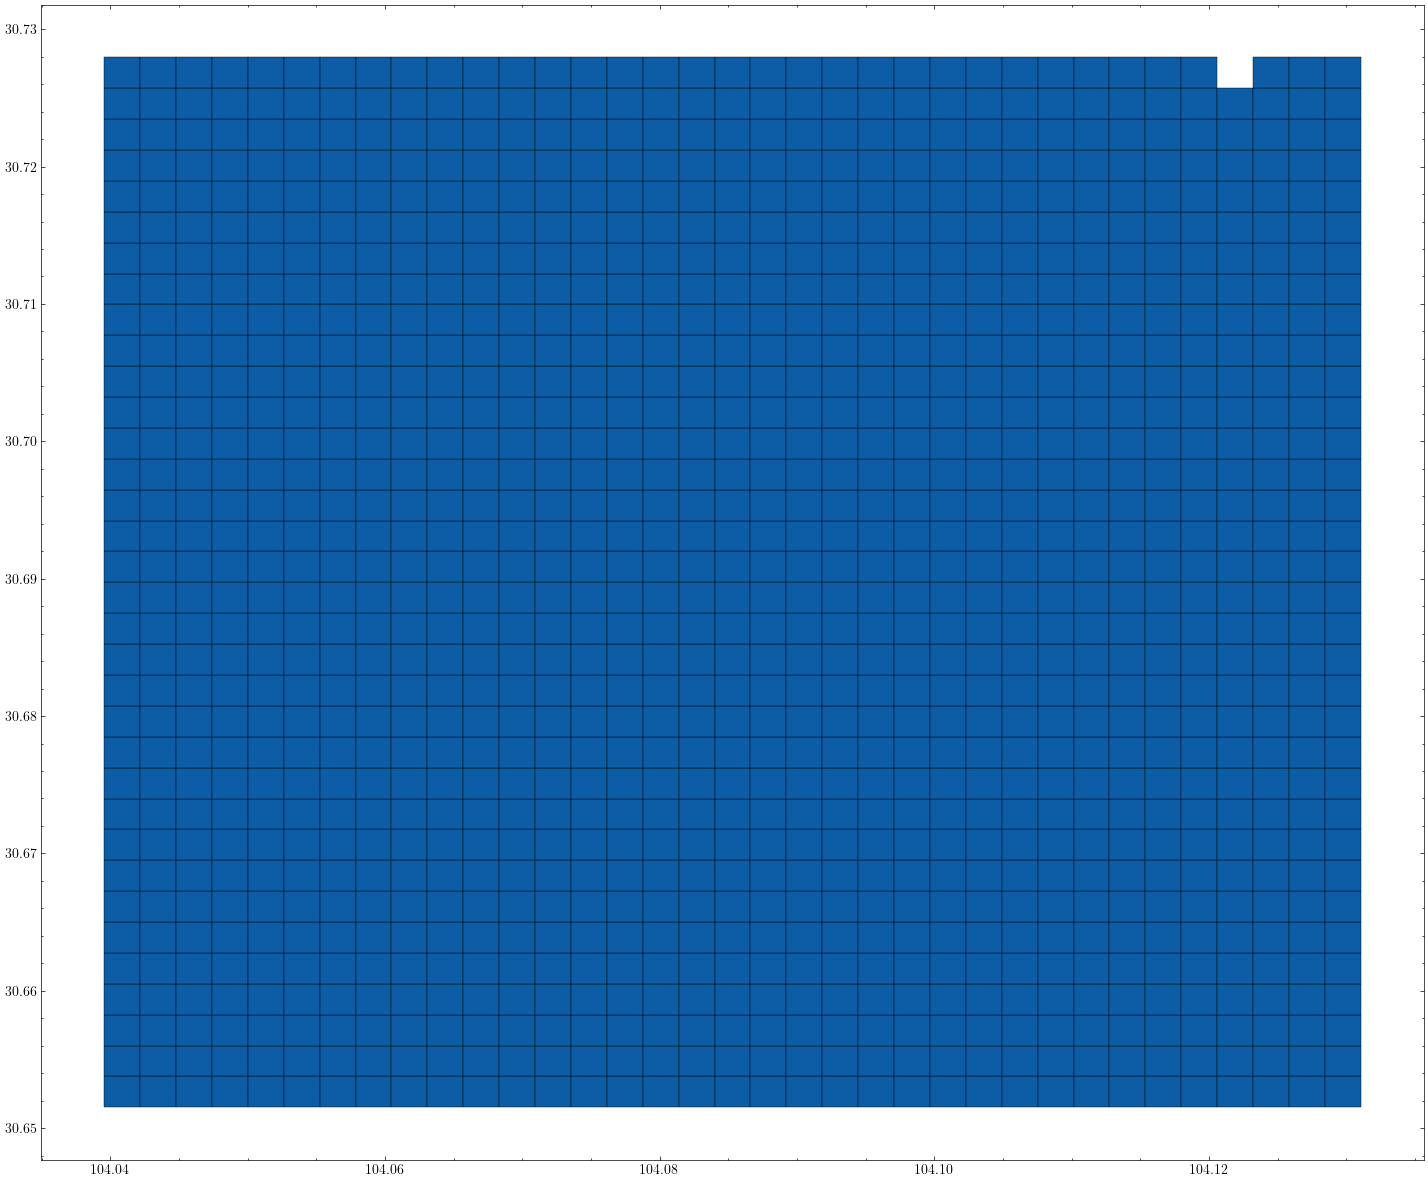

In [13]:
gdf_grid_filtered = gdf_grid.merge(tasks[['lon_index', 'lat_index']], 
                                     on=['lon_index', 'lat_index'], 
                                     how='inner')
gdf_grid_filtered.plot(edgecolor='black', linewidth=0.3, figsize=(20, 15))

In [14]:
ddf_cleaned.head()

,oid,wid,traj
0,92a1d44607c036fbc9db971258c0e013,f5e36c97e4a8052a2aa9c7f8ed0f969a,"[104.04538 30.70745 1538402919, 104.04538 30.7..."
1,0e95f18113ad01cf626289344fd39f4e,c5f1bba8b2cfad357a9ed65dc3021ff1,"[104.08169 30.6705 1538406898, 104.08169 30.67..."
2,7dceae818438b836e3d306296b4ccfbd,0e3f29616d126177f5db9bfb27be21de,"[104.04235 30.69204 1538334938, 104.04268 30.6..."
3,94bba68a63c866769c1c3b37834518fa,c480964f535eede621a1ac4dde7073a6,"[104.04714 30.7263 1538345323, 104.04698 30.72..."
4,8601cc60cfea2fc7f599ebf9b2a4d977,5f3cabc6ff9083e6c79f3f798a9c17e2,"[104.11542 30.65289 1538322576, 104.11574 30.6..."


In [15]:
ddf_expanded.head()

,wid,oid,lon,lat,dt,lon_index,lat_index
0,c5f1bba8b2cfad357a9ed65dc3021ff1,0e95f18113ad01cf626289344fd39f4e,104.08169,30.6705,2018-10-01 23:14:58,15,8
1,c5f1bba8b2cfad357a9ed65dc3021ff1,0e95f18113ad01cf626289344fd39f4e,104.08169,30.6705,2018-10-01 23:15:08,15,8
2,c5f1bba8b2cfad357a9ed65dc3021ff1,0e95f18113ad01cf626289344fd39f4e,104.08169,30.6705,2018-10-01 23:15:18,15,8
3,c5f1bba8b2cfad357a9ed65dc3021ff1,0e95f18113ad01cf626289344fd39f4e,104.08169,30.6705,2018-10-01 23:15:28,15,8
4,c5f1bba8b2cfad357a9ed65dc3021ff1,0e95f18113ad01cf626289344fd39f4e,104.08169,30.6705,2018-10-01 23:15:38,15,8


In [16]:
n, m = 1140, 565

In [17]:
output_worker_selected = os.path.join(dataset, 'worker_selected.csv')

if not os.path.exists(output_worker_selected):
    worker_selected = workers['wid'].sample(n=n, random_state=20240120)
    worker_selected.to_csv(output_worker_selected, index=False)

worker_selected = pd.read_csv(output_worker_selected)
worker_selected

,wid
0,9348e01c7de5b61c3bd91ddd4762b51e
1,eaa56a6808a7fae5e1bb650baf2a33d9
2,f84f051ce9a2477fc5b7cbbeab3c79bd
3,1d9b54e8463d1fc7f099ff68b43d5f8b
4,9c90f0b50f864d4c6d12b353f03eebae
...,...
1135,c86a4553ccdcf290cf3ce1afb87719d9
1136,0ef77e45f5cc8611e874e15aa0fc4a6d
1137,1a246d64b86ae19e6a74f3af15fd8a37
1138,b0cb89fc23aa41b05c41b9709c8e9960


In [18]:
output_task_selected = os.path.join(dataset, 'task_selected.csv')

if not os.path.exists(output_task_selected):
    task_selected = tasks.sample(n=m, random_state=20231225)
    task_selected['lat_lon'] = task_selected['lat_index'].astype(str) + ',' + task_selected['lon_index'].astype(str)
    task_selected.to_csv(output_task_selected, index=False)

task_selected = pd.read_csv(output_task_selected)
task_selected

,lon_index,lat_index,lat_lon
0,325,175,"175,325"
1,314,163,"163,314"
2,327,191,"191,327"
3,299,161,"161,299"
4,318,171,"171,318"
...,...,...,...
560,324,180,"180,324"
561,328,190,"190,328"
562,326,184,"184,326"
563,319,191,"191,319"


In [19]:
output_final = os.path.join(dataset, 'final')

ddf_expanded['lat_lon'] = ddf_expanded['lat_index'].astype(str) + ',' + ddf_expanded['lon_index'].astype(str)

if not os.path.exists(output_final) or len(os.listdir(output_final)) == 0:
    os.makedirs(output_final, exist_ok=True)
    ddf_expanded[ddf_expanded['wid'].isin(worker_selected['wid']) & 
                 ddf_expanded['lat_lon'].isin(task_selected['lat_lon'])
                ].to_parquet(output_final)

final_files = [os.path.join(output_final, i) 
                 for i in os.listdir(output_final) 
                 if i.startswith('part') and i.endswith('.parquet')]

ddf_final = dd.read_parquet(final_files)
ddf_final.head()

,wid,oid,lon,lat,dt,lon_index,lat_index,lat_lon
0,104e7d39e879d21e6d1b03a50395c238,737a2b0479e06ae7f98bababf23dca23,104.10418,30.68739,2018-10-01 08:42:28,319,176,"176,319"
1,104e7d39e879d21e6d1b03a50395c238,737a2b0479e06ae7f98bababf23dca23,104.10418,30.68739,2018-10-01 08:42:32,319,176,"176,319"
2,104e7d39e879d21e6d1b03a50395c238,737a2b0479e06ae7f98bababf23dca23,104.10418,30.68739,2018-10-01 08:42:35,319,176,"176,319"
3,104e7d39e879d21e6d1b03a50395c238,737a2b0479e06ae7f98bababf23dca23,104.10418,30.68739,2018-10-01 08:42:38,319,176,"176,319"
4,104e7d39e879d21e6d1b03a50395c238,737a2b0479e06ae7f98bababf23dca23,104.10419,30.68741,2018-10-01 08:42:41,319,176,"176,319"


In [43]:
# dd.compute(ddf_final.shape)

((19723760, 8),)

# Adapter: ArrivePro & Qualific

对每一个特定的工人（wid）、任务（lat_lon）：

arrive_pro：有记录天数除以总天数计算，代表到达当前任务的概率；

q_pro：质量达标（首先计算停留秒数大于阈值）天数除以有记录天数，代表完成该任务的概率。

In [60]:
output_final_csv = os.path.join(dataset, 'final', 'ddf_final.csv')
ddf_final['date'] = ddf_final['dt'].dt.date

if not os.path.exists(output_final_csv):
    ddf_final.drop(columns=['oid', 'lon', 'lat', 'lon_index', 'lat_index']
              ).to_csv(output_final_csv, single_file=True, index=False)
    
df_final = dd.read_csv(output_final_csv)
df_final['dt']=dd.to_datetime(df_final['dt'])
df_final.head()

,wid,dt,lat_lon,date
0,104e7d39e879d21e6d1b03a50395c238,2018-10-01 08:42:28,"176,319",2018-10-01
1,104e7d39e879d21e6d1b03a50395c238,2018-10-01 08:42:32,"176,319",2018-10-01
2,104e7d39e879d21e6d1b03a50395c238,2018-10-01 08:42:35,"176,319",2018-10-01
3,104e7d39e879d21e6d1b03a50395c238,2018-10-01 08:42:38,"176,319",2018-10-01
4,104e7d39e879d21e6d1b03a50395c238,2018-10-01 08:42:41,"176,319",2018-10-01


In [199]:
output_grouped_csv = os.path.join(dataset, 'grouped.csv')
meta = pd.DataFrame({'duration': pd.Series(dtype='float64')})
def calculate_stay_duration(group):
    group = group.sort_values('dt')
    time_diff = group['dt'].diff().dt.total_seconds()
    duration = time_diff[time_diff <= 15].sum()
    return pd.Series({'duration': duration})

if not os.path.exists(output_grouped_csv):
    grouped = df_final.groupby(['wid', 'lat_lon', 'date'])
    grouped.apply(calculate_stay_duration, meta=meta).reset_index(
        ).to_csv(output_grouped_csv, single_file=True, index=False)

df_grouped = pd.read_csv(output_grouped_csv)
df_grouped = df_grouped[df_grouped['duration'] > 0.0]
df_grouped['aux'] = df_grouped['wid'] + '_' + df_grouped['date']
df_grouped

,wid,lat_lon,date,duration,aux
0,00d5ac49f1d341319f8c2a76b84d1eca,"161,309",2018-10-14,6.0,00d5ac49f1d341319f8c2a76b84d1eca_2018-10-14
1,00d5ac49f1d341319f8c2a76b84d1eca,"162,316",2018-11-17,67.0,00d5ac49f1d341319f8c2a76b84d1eca_2018-11-17
3,00d5ac49f1d341319f8c2a76b84d1eca,"164,296",2018-11-17,13.0,00d5ac49f1d341319f8c2a76b84d1eca_2018-11-17
4,00d5ac49f1d341319f8c2a76b84d1eca,"164,303",2018-11-29,120.0,00d5ac49f1d341319f8c2a76b84d1eca_2018-11-29
5,00d5ac49f1d341319f8c2a76b84d1eca,"164,307",2018-11-29,109.0,00d5ac49f1d341319f8c2a76b84d1eca_2018-11-29
...,...,...,...,...,...
1294418,ffb90df18780475e861cb8c87617ad49,"189,327",2018-10-26,9.0,ffb90df18780475e861cb8c87617ad49_2018-10-26
1294419,ffb90df18780475e861cb8c87617ad49,"189,329",2018-10-26,2.0,ffb90df18780475e861cb8c87617ad49_2018-10-26
1294422,ffb90df18780475e861cb8c87617ad49,"191,308",2018-10-09,52.0,ffb90df18780475e861cb8c87617ad49_2018-10-09
1294423,ffb90df18780475e861cb8c87617ad49,"191,312",2018-10-14,42.0,ffb90df18780475e861cb8c87617ad49_2018-10-14


In [214]:
task_trick = df_grouped[['lat_lon', 'aux']].groupby(['lat_lon']).nunique().reset_index().sort_values(by=['aux'])
df_grouped = df_grouped[df_grouped['lat_lon'].isin(task_trick[task_trick['aux'] > 2500]['lat_lon'])] 
df_grouped

,wid,lat_lon,date,duration,aux
0,00d5ac49f1d341319f8c2a76b84d1eca,"161,309",2018-10-14,6.0,00d5ac49f1d341319f8c2a76b84d1eca_2018-10-14
4,00d5ac49f1d341319f8c2a76b84d1eca,"164,303",2018-11-29,120.0,00d5ac49f1d341319f8c2a76b84d1eca_2018-11-29
5,00d5ac49f1d341319f8c2a76b84d1eca,"164,307",2018-11-29,109.0,00d5ac49f1d341319f8c2a76b84d1eca_2018-11-29
6,00d5ac49f1d341319f8c2a76b84d1eca,"165,318",2018-10-14,6.0,00d5ac49f1d341319f8c2a76b84d1eca_2018-10-14
7,00d5ac49f1d341319f8c2a76b84d1eca,"166,306",2018-11-17,51.0,00d5ac49f1d341319f8c2a76b84d1eca_2018-11-17
...,...,...,...,...,...
1294414,ffb90df18780475e861cb8c87617ad49,"188,308",2018-11-18,21.0,ffb90df18780475e861cb8c87617ad49_2018-11-18
1294417,ffb90df18780475e861cb8c87617ad49,"189,319",2018-11-21,15.0,ffb90df18780475e861cb8c87617ad49_2018-11-21
1294418,ffb90df18780475e861cb8c87617ad49,"189,327",2018-10-26,9.0,ffb90df18780475e861cb8c87617ad49_2018-10-26
1294422,ffb90df18780475e861cb8c87617ad49,"191,308",2018-10-09,52.0,ffb90df18780475e861cb8c87617ad49_2018-10-09


In [215]:
df_grouped['wid'].nunique()

1140

In [216]:
df_grouped['lat_lon'].nunique()

181

In [217]:
# Step 1: Calculate the number of days each driver visits each lat_lon
visits_per_day = df_grouped.groupby(['wid', 'lat_lon'])['date'].nunique().reset_index()
visits_per_day = visits_per_day.rename(columns={'date': 'days_visited'})
visits_per_day

,wid,lat_lon,days_visited
0,00d5ac49f1d341319f8c2a76b84d1eca,"161,299",2
1,00d5ac49f1d341319f8c2a76b84d1eca,"161,302",1
2,00d5ac49f1d341319f8c2a76b84d1eca,"161,303",2
3,00d5ac49f1d341319f8c2a76b84d1eca,"161,305",2
4,00d5ac49f1d341319f8c2a76b84d1eca,"161,308",1
...,...,...,...
181948,ffb90df18780475e861cb8c87617ad49,"193,307",9
181949,ffb90df18780475e861cb8c87617ad49,"193,308",7
181950,ffb90df18780475e861cb8c87617ad49,"194,299",8
181951,ffb90df18780475e861cb8c87617ad49,"194,301",7


In [218]:
# Step 2: Calculate the number of days with duration > 30 for each driver at each lat_lon
filtered_df = df_grouped[df_grouped['duration'] > 20]
days_with_long_duration = filtered_df.groupby(['wid', 'lat_lon'])['date'].nunique().reset_index()
days_with_long_duration = days_with_long_duration.rename(columns={'date': 'days_with_long_duration'})
days_with_long_duration

# Step 3: Merge the datasets and calculate the ratio
merged_data = pd.merge(days_with_long_duration, visits_per_day, on=['wid', 'lat_lon'], how='right')
merged_data['duration_ratio'] = 1.0 * merged_data['days_with_long_duration'] / merged_data['days_visited']
merged_data.fillna(0, inplace=True)

merged_data

,wid,lat_lon,days_with_long_duration,days_visited,duration_ratio
0,00d5ac49f1d341319f8c2a76b84d1eca,"161,299",1.0,2,0.500000
1,00d5ac49f1d341319f8c2a76b84d1eca,"161,302",0.0,1,0.000000
2,00d5ac49f1d341319f8c2a76b84d1eca,"161,303",1.0,2,0.500000
3,00d5ac49f1d341319f8c2a76b84d1eca,"161,305",2.0,2,1.000000
4,00d5ac49f1d341319f8c2a76b84d1eca,"161,308",0.0,1,0.000000
...,...,...,...,...,...
181948,ffb90df18780475e861cb8c87617ad49,"193,307",2.0,9,0.222222
181949,ffb90df18780475e861cb8c87617ad49,"193,308",4.0,7,0.571429
181950,ffb90df18780475e861cb8c87617ad49,"194,299",2.0,8,0.250000
181951,ffb90df18780475e861cb8c87617ad49,"194,301",0.0,7,0.000000


In [219]:
all_combinations = pd.MultiIndex.from_product([df_grouped['wid'].unique(), df_grouped['lat_lon'].unique()], names=['wid', 'lat_lon']).to_frame(index=False)
arrive_pro = df_grouped[['wid', 'lat_lon', 'date']].groupby(['wid', 'lat_lon']).nunique().reset_index()
arrive_pro['date'] /= arrive_pro['date'].max()
arrive_pro = pd.merge(all_combinations, arrive_pro, on=['wid', 'lat_lon'], how='left').fillna(0).rename(columns={'date': 'ArrivePro'})
arrive_pro.sort_values(by=['ArrivePro'], ascending=False)

,wid,lat_lon,ArrivePro
57852,4a2e3ae9803ff1ac822fc1723824431c,"180,301",1.000000
177495,e039d99901d6ed3c2ae4bb1895f8a5d6,"193,308",0.886364
148679,be646fb876b09b4b22a85070d371b229,"176,318",0.886364
23903,1f45429e64dbf159924dc57d7f33de82,"182,319",0.863636
148610,be646fb876b09b4b22a85070d371b229,"176,319",0.840909
...,...,...,...
52236,430617e2dc4ed669645f71ae9edbcec7,"172,315",0.000000
90766,783ff212e07209adffac5c1aea17141d,"170,312",0.000000
52282,430617e2dc4ed669645f71ae9edbcec7,"190,306",0.000000
189303,ed54a3c208078f0f2d528cf6bb666788,"183,310",0.000000


In [238]:
combined = pd.merge(arrive_pro, merged_data, on=['wid', 'lat_lon'], how='right')
combined = pd.merge(df_grouped[['wid']].drop_duplicates(ignore_index=True).reset_index(), combined, on=['wid'], how='right')
combined['index'] = combined['index'] + 1
combined.drop(columns=['days_with_long_duration', 'days_visited'], inplace=True)
combined = combined.rename(columns={'duration_ratio':'qPro'})
np.random.seed(0)
combined['taskFare'] = np.random.randint(10,25,size=(combined.shape[0], 1))
combined['travelFare'] = np.random.randint(10,25,size=(combined.shape[0], 1))

combined = pd.merge(combined.groupby(by=['wid'])['qPro'].mean().reset_index().rename(columns={'qPro':'qPro_avg'}), combined, on=['wid'], how='right')
combined['Fare'] = combined['taskFare'] + combined['travelFare']
combined['Pro'] = combined['ArrivePro'] * combined['qPro_avg']
combined

,wid,qPro_avg,index,lat_lon,ArrivePro,qPro,taskFare,travelFare,Fare,Pro
0,00d5ac49f1d341319f8c2a76b84d1eca,0.401736,1,"161,299",0.045455,0.500000,22,18,40,0.018261
1,00d5ac49f1d341319f8c2a76b84d1eca,0.401736,1,"161,302",0.022727,0.000000,15,16,31,0.009130
2,00d5ac49f1d341319f8c2a76b84d1eca,0.401736,1,"161,303",0.045455,0.500000,10,23,33,0.018261
3,00d5ac49f1d341319f8c2a76b84d1eca,0.401736,1,"161,305",0.045455,1.000000,13,17,30,0.018261
4,00d5ac49f1d341319f8c2a76b84d1eca,0.401736,1,"161,308",0.022727,0.000000,21,14,35,0.009130
...,...,...,...,...,...,...,...,...,...,...
181948,ffb90df18780475e861cb8c87617ad49,0.521549,1140,"193,307",0.204545,0.222222,21,15,36,0.106681
181949,ffb90df18780475e861cb8c87617ad49,0.521549,1140,"193,308",0.159091,0.571429,14,15,29,0.082974
181950,ffb90df18780475e861cb8c87617ad49,0.521549,1140,"194,299",0.181818,0.250000,17,21,38,0.094827
181951,ffb90df18780475e861cb8c87617ad49,0.521549,1140,"194,301",0.159091,0.000000,23,15,38,0.082974


In [242]:
output = combined[['index', 'lat_lon', 'taskFare', 'Pro', 'qPro_avg', 'Fare', 'ArrivePro']]
output['lat_lon'] = output['lat_lon'].apply(lambda s: s.replace(',', '-'))
output.round({'Pro':2, 'qPro_avg':2, 'ArrivePro':2,}).to_csv('CarInformation.txt', index=False, header=None)

In [247]:
output['10'] = 10
output[['lat_lon', '10']].to_csv('POI.txt', index=False, header=None)